In [454]:
!pip3 install pandas

269192.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [455]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


<div style="background: linear-gradient(to right, #3c3c3c, #6e6e6e); color:white; padding:10px; border-radius:10px; font-size:24px; text-align:center;">
    Assignment #2 - Shallow Models Training, Validation and Tuning
</div>


# <font color='#3c3c3c'>Task 1 - EDA</font>

In [456]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


First thing I will do is use info() to know the size of the dataset and maybe additional useful information. 

In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


 This dataset is much larger that the one in assignment #1, it has 17379 entries.. This means that we can split it like before 70/30/30 or do it more drastically with 60/20/20 since there is more data and we will still be retaining enough data in each subset for reliable training and evaluation. A larger dataset also means that their is more data, which means more diversity, which leads to the model learning more generalizable relationships. Aditionally, the results also confirm that there will be no need for data imputation since there are no missing values. 

Before deciding what to do for the EDA task I want to take a look at the chart the professor provided with a summary of the dataset. This way, we can better understand our dataset; specifically the variables and type of data that we have.

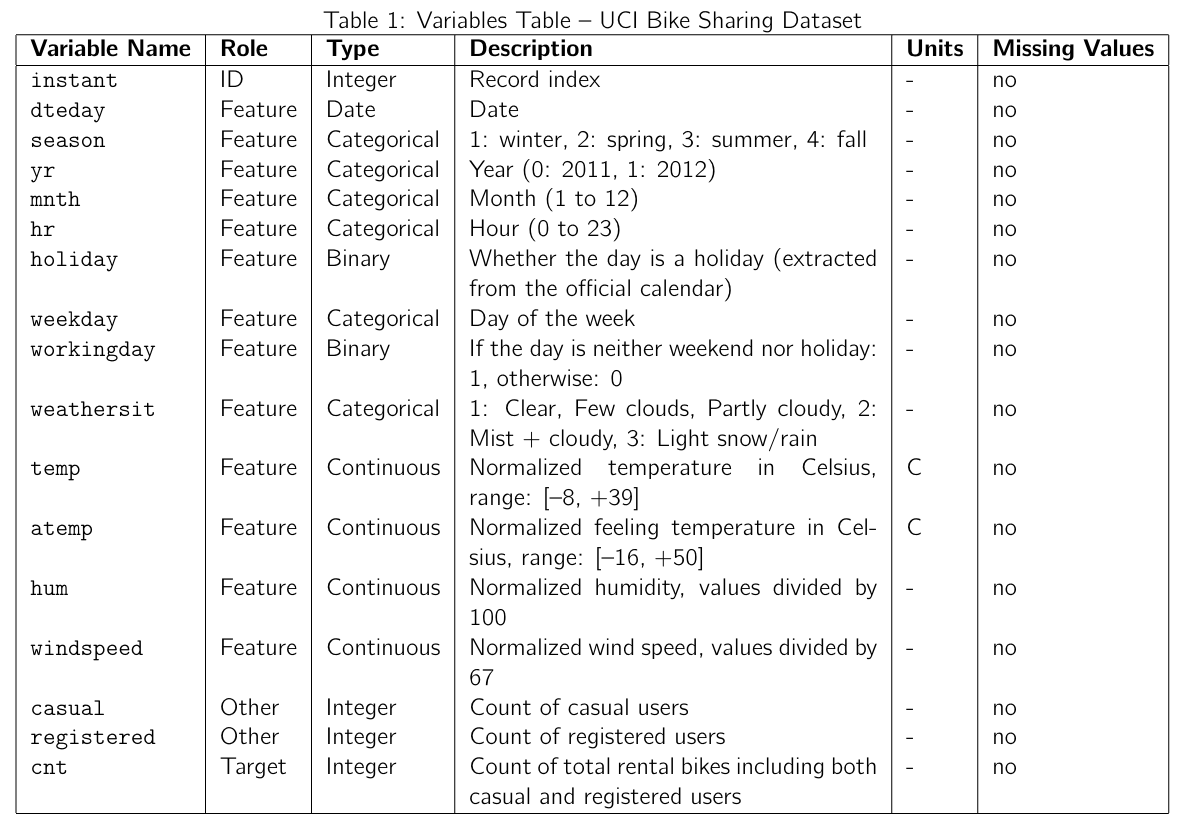

In [458]:
from IPython import display
display.Image("info.png")

Based on the dataset, there are 16 columns, including the target variable (cnt). Three columns (instant, casual, and registered) are labeled as 'other' or 'ID', meaning they are not true features, leaving us with 13 actual features:

- 4 are continuous (temp, atemp, hum, windspeed).
- 6 are categorical (season, yr, mnth, hr, weekday, weathersit).
- 2 are binary (holiday, workingday).
- 1 is a date (dteday).
It also nice to know right off the bat that there are no missing values in the dataset, which means that no data imputation will be required. 

Additionally, analyzing the descriptions of the columns, there are a few that are redundant or simply don't provide any helpful information. I am considering dropping the following columns: 

- instant: The ID is useless, it is just an index. 
- dteday: The date is not relevant since we are given the "category" of the day in other columns, which is what really matters.
- holiday, weekday, workingday: These three seem to be redundant. I wonder if it is possible to choose only one or 2 and drop the rest.
- casual and registered: I can keep one since it will tell me what the other one is, or I can remove it since it is irrelevant to our objective (Prediction of bike rental count hourly based on the environmental and seasonal settings)

To make sure that I make the best decision, I will have to further analyze a few of them to get to a conclusion.

First, we have to take to take a look at the distribution of the target variable to better understand its shape and check for outliers. 

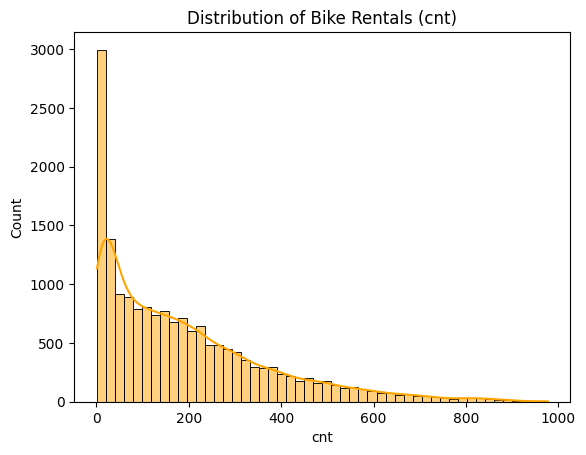

Skewness: 1.2774116037490577


In [459]:
sns.histplot(df['cnt'], kde=True, bins=50, color='orange')
plt.title('Distribution of Bike Rentals (cnt)')
plt.show()

print("Skewness:", df['cnt'].skew())


The graph and the skewness value (1.27) indicate that the target variable is right-skewed. This suggests that a linear model may perform poorly, as it might struggle to capture the underlying distribution. In theory, we would need to apply a transformation to make the distribution more symmetric if we want to use a linear model effectively. However, other models exist that can handle the skewness well (more robust) without sacrificing generalization (I will elaborate on this later). This also means that we're gonna have to be careful in the splitting process so that all sets are representative of the full range of data points to avoid bias. 

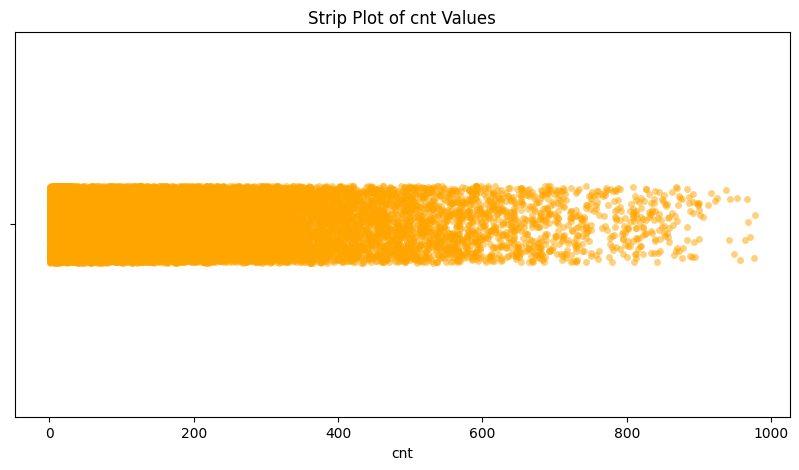

In [460]:
plt.figure(figsize=(10, 5))
sns.stripplot(x=df["cnt"], jitter=True, alpha=0.5, color='orange')  # `jitter` spreads points slightly
plt.title("Strip Plot of cnt Values")
plt.show()


With the strip plot above I wanted to see if I was able to spot any extreme outliers since in the bar plot it was not visible no matter the number of bins I chose. As seen in the bar graph, the distribution is heavily right-skewed, with a high density of lower values and a sharp decrease in frequency as values increase. In the strip plot we can see this more clearly and we can also observe that there are no points that exceed 1000, and there is a noticeable drop in density for values above 900. These could be considered possible outliers, but further analysis is required. 

I will calculate the IQR and print those data points that exceed the upper bound, which will idenitfy extreme outliers. 

In [461]:
Q1 = df["cnt"].quantile(0.25)
Q3 = df["cnt"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + (2.7 * IQR)  

outliers = df[df["cnt"] > upper_bound]
print(outliers[["instant", "dteday", "cnt", "temp", "hum", "windspeed"]]) 

       instant      dteday  cnt  temp   hum  windspeed
10622    10623  2012-03-23  957  0.72  0.42     0.1642
14293    14294  2012-08-23  941  0.74  0.48     0.2239
14725    14726  2012-09-10  968  0.62  0.35     0.2985
14748    14749  2012-09-11  970  0.70  0.28     0.0000
14773    14774  2012-09-12  977  0.66  0.44     0.2537
14964    14965  2012-09-20  976  0.64  0.50     0.2239
15084    15085  2012-09-25  967  0.66  0.39     0.2836
15108    15109  2012-09-26  953  0.74  0.48     0.2985
15444    15445  2012-10-10  948  0.58  0.43     0.2239
15588    15589  2012-10-16  943  0.52  0.39     0.1940
15756    15757  2012-10-23  938  0.68  0.41     0.0000
15780    15781  2012-10-24  963  0.66  0.47     0.0000


The results show 12 potential outliers, which is a small number considering the size of the dataset (12/17379 = ~0.0007%). I suspect that keeping or removing these 12 points won’t significantly impact the overall distribution so maybe we shouldn't even bother removign these. However, to confirm this, I will plot the distribution with and without the outliers and print the summary statistics to have a clearer understanding of the effect it will have. 

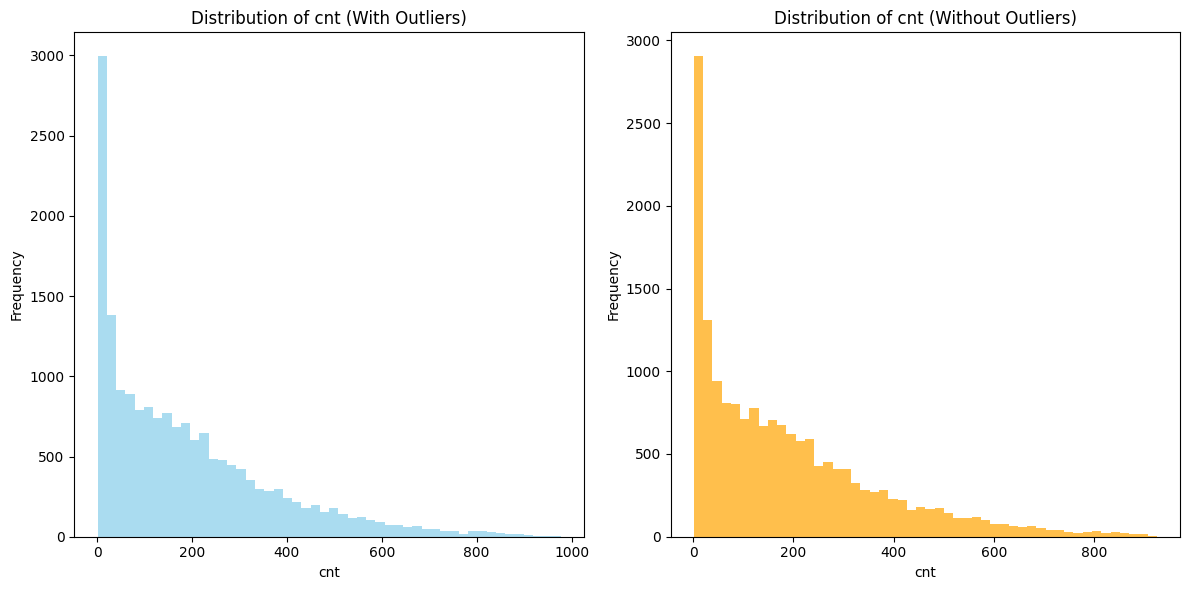

In [462]:
### CREATED WITH CHATGPT ###

df_no_outliers = df[df["cnt"] <= upper_bound]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df["cnt"], bins=50, color='skyblue', alpha=0.7)
plt.title("Distribution of cnt (With Outliers)")
plt.xlabel("cnt")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_no_outliers["cnt"], bins=50, color='orange', alpha=0.7)
plt.title("Distribution of cnt (Without Outliers)")
plt.xlabel("cnt")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [463]:
original_stats = df["cnt"].describe()
cleaned_stats = df_no_outliers["cnt"].describe()

original_mean = df["cnt"].mean()
cleaned_mean = df_no_outliers["cnt"].mean()

original_median = df["cnt"].median()
cleaned_median = df_no_outliers["cnt"].median()

original_std = df["cnt"].std()
cleaned_std = df_no_outliers["cnt"].std()

original_skew = df["cnt"].skew()
cleaned_skew = df_no_outliers["cnt"].skew()

print("Original Data Statistics:")
print(f"Mean: {original_mean}, Median: {original_median}, Std: {original_std}, Skew: {original_skew}")

print("\nCleaned Data Statistics:")
print(f"Mean: {cleaned_mean}, Median: {cleaned_median}, Std: {cleaned_std}, Skew: {cleaned_skew}")


Original Data Statistics:
Mean: 189.46308763450142, Median: 142.0, Std: 181.38759909186473, Skew: 1.2774116037490577

Cleaned Data Statistics:
Mean: 188.93176714458457, Median: 142.0, Std: 180.31974431300907, Skew: 1.2563408640704234


As suspected, the results show minimal impact from keeping or removing the outliers. The mean, median, and standard deviation remain almost unchanged, although there is a slight difference of about 0.02 in skewness, which may suggest that removing the outliers could lead to a slightly more symmetrical distribution. However, I don't believe the impact is significant enough to remove the outliers. I will keep the outliers.

### <font color='6e6e6e'>Temporal Features</font>

Now, let's move to analyzing the relationship between the target and other variables. It is important to see these relationships not only for correlation, but becuase we have a few temporal variables which may affect our target variable significantly.

- **hr**: Important to analyze because rentals are definitely affected by the time of the day and this will reveal interesting patterns such as peak hours.

- **weekday**: Rentals are probably also affected by the day of the week (weekday or weekend). It will reveal if rentals are more common for trips on the weekend or for transportation to work/school in weekdays. 

- **mntv**: Again, the month will probably have an impact on rentals since maybe during the colder months rentals decrease while in warmer months they probably increase.

- **season**: Directly related to the month, as seasons (spring, summer, fall, winter) are determined by the month. 

**Quick note**: the code for the graphs were generated by ChatGPT. I gave it the variable names, the name of the dataset, and stated what type of graphs I wanted for each. 

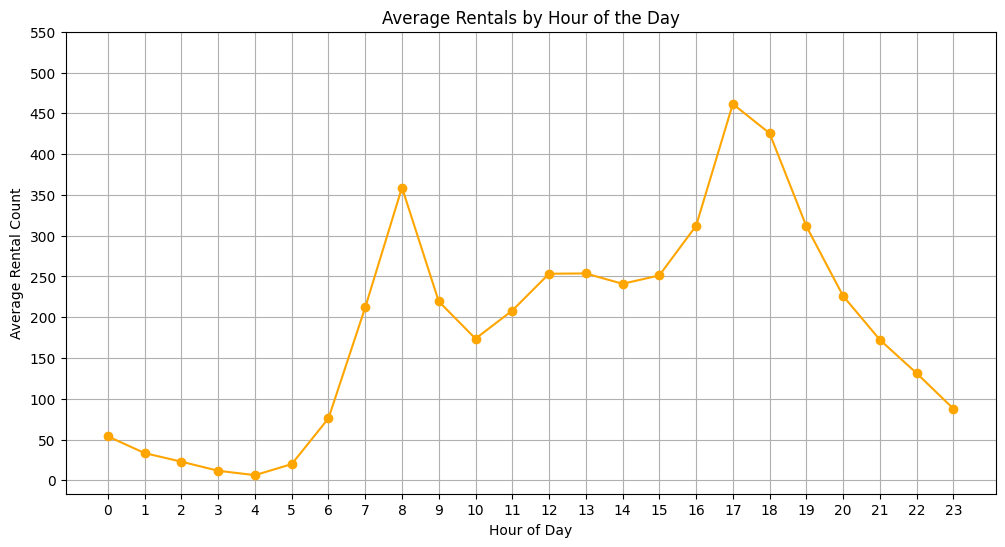

In [464]:
### RENTALS BY HOUR ###

plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hr')['cnt'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='orange')
plt.title('Average Rentals by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rental Count')
plt.grid(True)

plt.xticks(range(0, 24)) 
plt.yticks(np.arange(0, hourly_avg.max() + 100, 50)) 

plt.show()

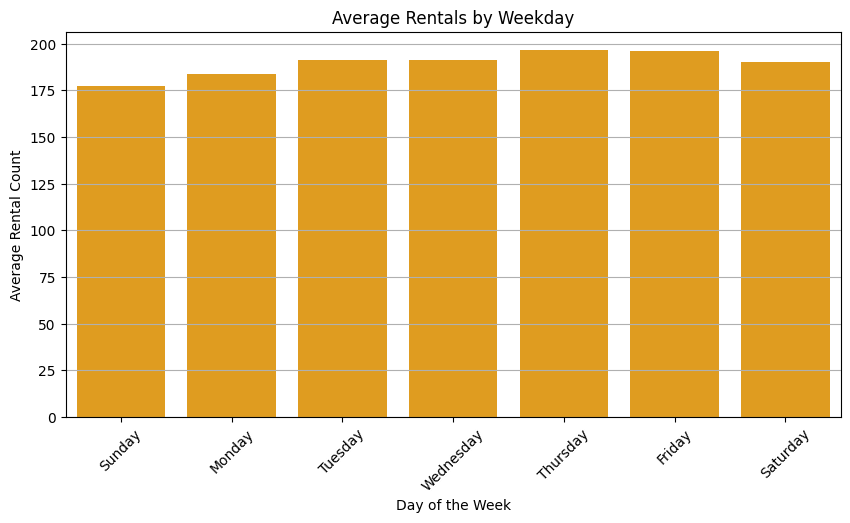

In [465]:
### RENTALS BY WEEKDAY ###

df['weekday'] = df['weekday'].map({
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
    4: 'Thursday', 5: 'Friday', 6: 'Saturday'
})
plt.figure(figsize=(10, 5))
weekday_avg = df.groupby('weekday')['cnt'].mean().reindex([
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'
])
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, color='orange')
plt.title('Average Rentals by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Average Rental Count')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


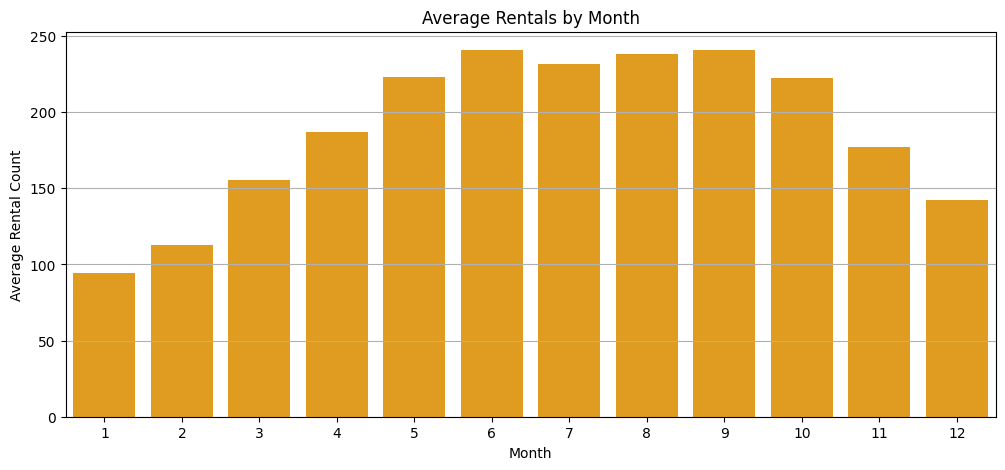

In [466]:
### RENTALS BY MONTH ###

plt.figure(figsize=(12, 5))
month_avg = df.groupby('mnth')['cnt'].mean()
sns.barplot(x=month_avg.index, y=month_avg.values, color='orange')
plt.title('Average Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Rental Count')
plt.grid(True, axis='y')
plt.show()


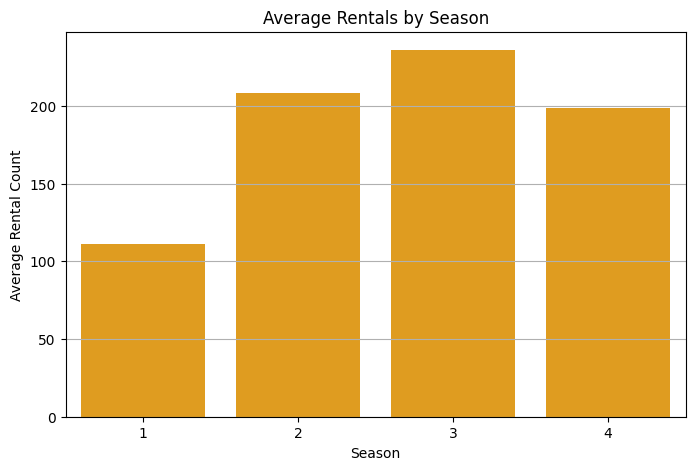

In [467]:
### RENTALS BY SEASON ###

plt.figure(figsize=(8, 5))
season_avg = df.groupby('season')['cnt'].mean()
sns.barplot(x=season_avg.index, y=season_avg.values, color='orange')
plt.title('Average Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Average Rental Count')
plt.grid(True, axis='y')
plt.show()

**Conclusion on relationhsips**

- **Rentals by hours**: The graph reveals two peak hours for rentals: one at 8 AM and another at 5 PM. At 8 AM, rentals reach approximately 360, and at 5 PM, they peak at around 465 rentals. The graph also shows that 4 AM experiences the lowest rentals, which gradually increase until 8 AM, where rentals peak. After 8 AM, there is a dip in rentals until 10 AM, followed by a steady increase reaching 250 rentals per hour between 12 PM and 1 PM. Then it reaches the second peak after which rentals significantly drop for the remainder of the evening. The peak hours may be related to the times people go to work 8-9 to the time people go back home 5. So, probably bikes are being rented for commmuting purposes. This is an important feature to predict rentals.

- **Rentals by Weekday**: The graph indicates that there is no significant variation in rental counts across the days of the week. The average rentals per day range from approximately 180 to 200, suggesting that weekday doesn't have an really have an influence. This is contradicts the assumption about rentals being for commuting. If that was the case, then weekdays would have higher amount of rentals than weekends. The graph shows that people are equally likely to rent bikes during weekdays as they are on weekend, therefore it could be potentially dropped. 

- **Rentals by Month**: The bar plot show a visible effect on rentals. The month with the least amount of average rentals is January, while the months with the highest average are June and September. The results are intuitive since at the beginning of the year rentals are low and they start increasing through the months as the weather get warmer. The gradual increase in rentals from January to June aligns with the warmer seasons, suggesting that weather or temperature is a strong determinant of rental behavior. Rentals appear to be stable in June and September, with a sharp drop in October, likely due to winter starting.

- **Rentals by Season**: As expected, summer has the highest average rentals, with over 200 rentals per day on average, while winter has the lowest, at around 105 rentals per day on average. Spring and fall have similar averages, ranging between 200 and 210 rentals, indicating that people tend to rent bikes more during the warmer seasons. Since season is derived from month, it may be a good idea to drop season to reduce redundancy. 


### <font color='6e6e6e'>Binary Features</font>

Now I will move on to analyze the reltionship between the target value and the binary features: workingday and holiday. 

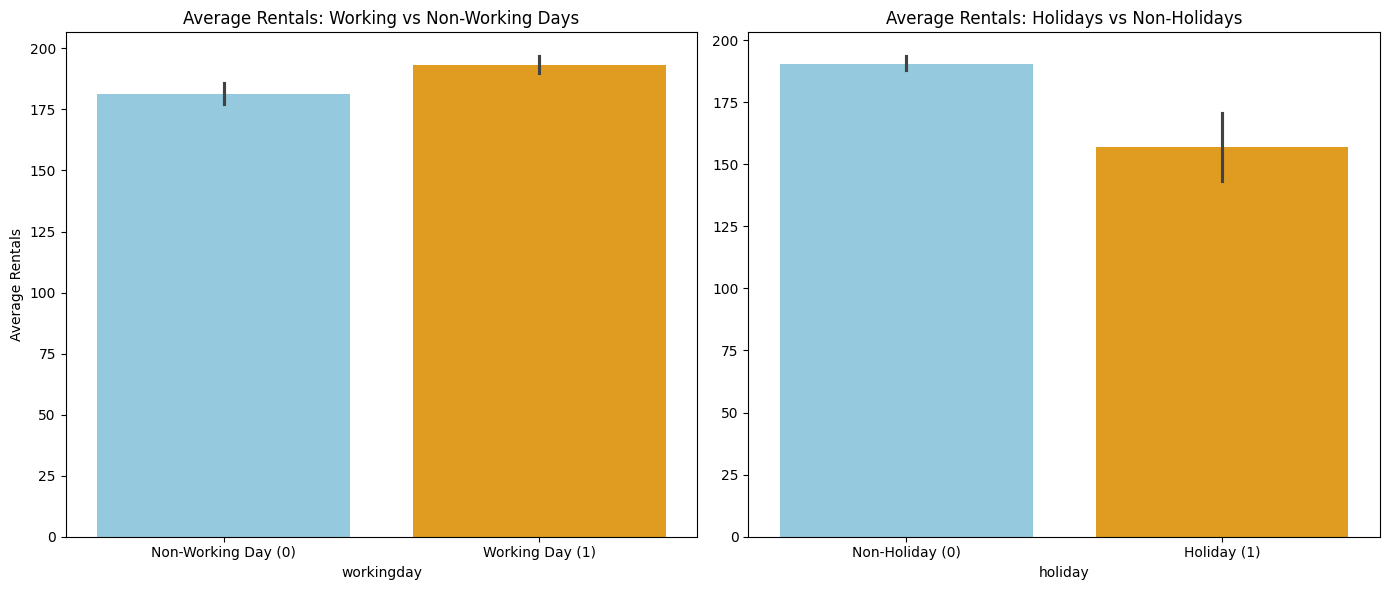

In [468]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: workingday vs cnt
sns.barplot(x='workingday', y='cnt', hue='workingday', data=df, ax=axes[0],
            palette={0: 'skyblue', 1: 'orange'}, legend=False)
axes[0].set_title('Average Rentals: Working vs Non-Working Days')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Working Day (0)', 'Working Day (1)'])
axes[0].set_ylabel('Average Rentals')

# Plot 2: holiday vs cnt
sns.barplot(x='holiday', y='cnt', hue='holiday', data=df, ax=axes[1],
            palette={0: 'skyblue', 1: 'orange'}, legend=False)
axes[1].set_title('Average Rentals: Holidays vs Non-Holidays')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Holiday (0)', 'Holiday (1)'])
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


The results show a very weak relationship between cnt and workingday. Eventhough rentals increase during working days, the average only increaes by around 15. The relationship between cnt and holiday is a bit more visible, but I still don't think is a major discovery. Rentals on holidays seem to decrease from ~185 on non-holidays to ~152 on holidays. 
The analysis reveals a very weak relationship between the target variable (cnt) and the binary feature workingday. Although the average number of rentals is slightly higher on working days, the difference is minimal, increasing by only around 15 rentals.
In contrast, the relationship between cnt and holiday is slightly more noticeable. The average number of rentals drops from approximately 185 on non-holidays to 152 on holidays, indicating a slight decrease in bike usage during public holidays. However, even this change doesnt seem to strongly influence the overall model. 

While workingday and holiday do not show strong individual correlations with the target variable cnt, it may still be valuable to keep them during model training, especially in combination with other features like hour, weekday, or season. For example, bike rental behavior might change on working days at certain hours, even if the overall daily average doesn’t show a large difference. This could become more visible through interactions in more advanced models. I will keep both for now and contnue analyzing them.

### <font color='6e6e6e'>Weather-Related Features</font>

Finally, I will analyze the relationship between cnt and the last set of features, weather-related features. These are important features since the objective of our model is to predict rentals based on environmental settings as well. 

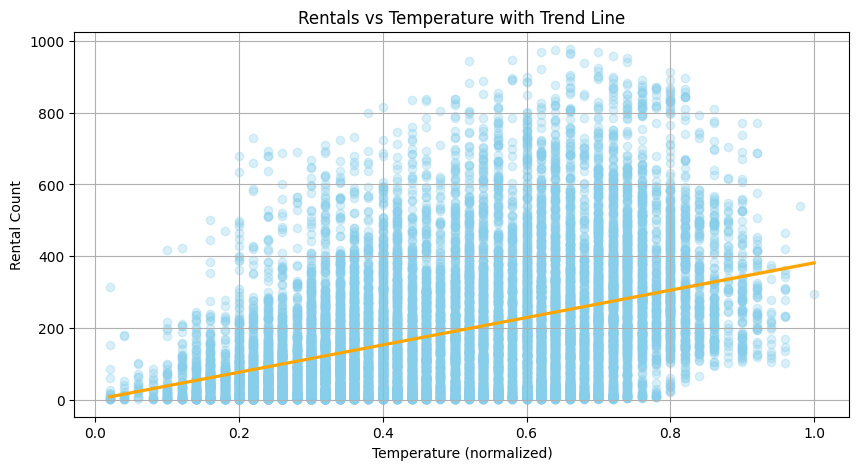

In [469]:
## RENTALS VS TEMP  ##
plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='temp', y='cnt', scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'},color='skyblue' )
plt.title('Rentals vs Temperature with Trend Line')
plt.xlabel('Temperature (normalized)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.show()

The scatter plot between temperature (temp) and bike rental count (cnt) clearly shows a positive linear relationship. As temperature increases, the rental count tends to rise as well, which is expected since warmer weather generally encourages more outdoor activities. However, there is a noticeable slight decrease in rental density as the normalized temperature surpasses a value of 0.8. This suggests that as temperatures approach higher, potentially uncomfortable levels, fewer people rent bikes. This could indicate that beyond a certain point, the heat becomes less favorable for biking (which we know it does), which may explain the dip in rental activity.

Additionally, the scatter plot shows vertical clustering of points at certain temperature values, indicating that the temperature data in the dataset was likely recorded at regular intervals. This pattern suggests a consistent, periodic collection of temperature readings.

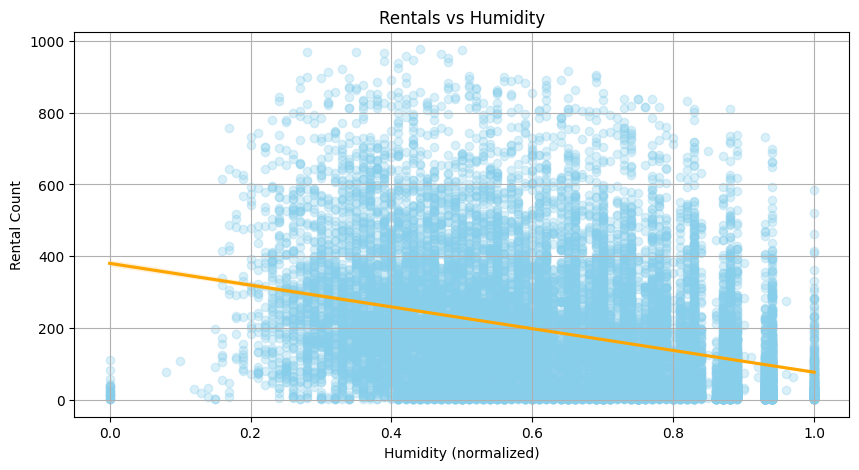

In [470]:
## RENTALS VS HUMIDITY  ##

plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='hum', y='cnt', scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'},color='skyblue' )
plt.title('Rentals vs Humidity')
plt.xlabel('Humidity (normalized)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.show()

The scatter plot is a difficult to analyze because of the significant variance at each humidity point. However, despite the noise, the trend line indicates a weak negative relationship between humidity and rental count.  This makes sense becasue as humidity increases it becomes more and more uncomfortable to drive a bike which of course means less rentals. It is instresting though, the lack of density in the normalized humidity values between 0 and 0.2. This could suggest that very low humidity (likely associated with colder weather) is rare in the dataset. It might also indicate that in these conditions, people may be less inclined to rent bikes due to the colder temperatures, further supporting the idea that extreme cold, rather than humidity alone, may also discourage bike rentals.

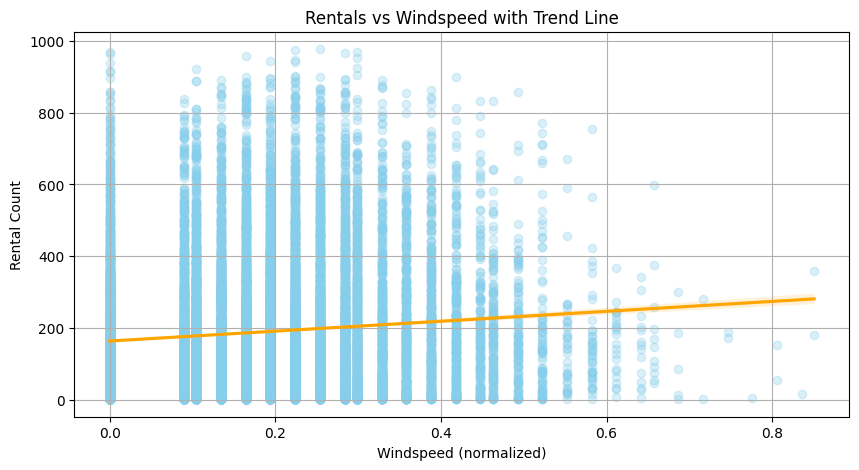

In [471]:
## RENTALS VS WINSPEED ##
plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='windspeed', y='cnt', scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'}, color='skyblue')
plt.title('Rentals vs Windspeed with Trend Line')
plt.xlabel('Windspeed (normalized)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.show()

Unlike temperature and humidity, the orange trend line in this graph suggests a very weak positive correlation between windspeed and rentals,  which might seem counterintuitive. However, the trend is so faint that it’s likely statistically insignificant. This might be due to the fact that most data points are concentrated at lower windspeed levels (see how most points are left of 0.5). 

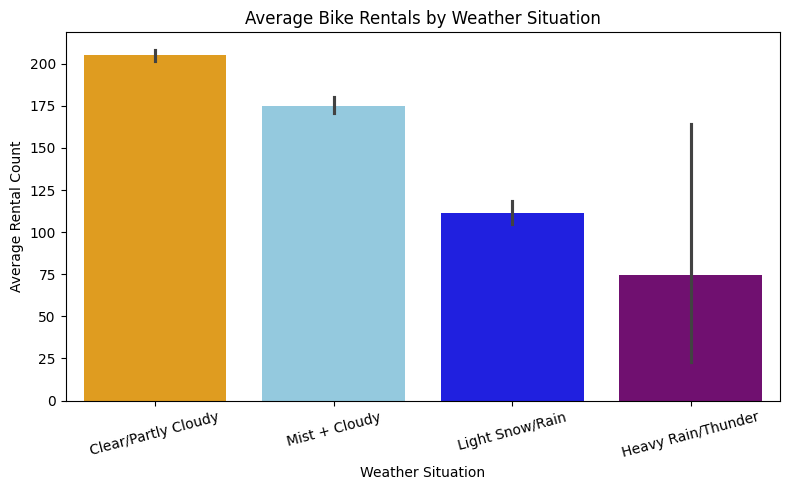

In [472]:
## RENTALS VS WEATHER SITUATION ##

# Create a copy of the DataFrame to avoid modifying the original one
df_copy = df.copy()

# Map weather situation labels to the copied DataFrame
weather_labels = {
    1: 'Clear/Partly Cloudy',
    2: 'Mist + Cloudy',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain/Thunder'
}
df_copy['weather_label'] = df_copy['weathersit'].map(weather_labels)

# Plot the data using the copy
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_copy,  # Use the copied DataFrame
    x='weather_label', 
    y='cnt', 
    hue='weather_label', 
    palette=['orange', 'skyblue', 'blue', 'purple'], 
    legend=False
)

# Customize the plot
plt.title('Average Bike Rentals by Weather Situation')
plt.xlabel('Weather Situation')
plt.ylabel('Average Rental Count')
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()



The analysis reveals a strong and clear relationship between weather conditions (weathersit) and the number of bike rentals (cnt). The trend aligns with what we would intuitively expect:

- Clear/Partly Cloudy: This weather condition shows the highest average rentals (around 200). It makes sense that good weather encourages people to rent bikes.

- Mist + Cloudy: Rentals are still fairly high in this category, but there’s a slight drop compared to clear skies (around 175)

- Light Snow/Rain: Weather conditions here cause a noticeable decline in rentals. The average count drops to around 110 rentals.

- Heavy Rain/Thunder: The worst weather condition shows the lowest average rentals, with a significant drop to about 75 rentals.

Overall, this suggests a linear negative relationship: As the weather worsens, the number of bike rentals decreases. 

### <font color='6e6e6e'>Droppping columns</font>

Now, I want to decide what columns I should drop now since I have a much better understanding of the data and the relationships. To do so, I will run one final test to make final decisions, a correlation heatmap. 

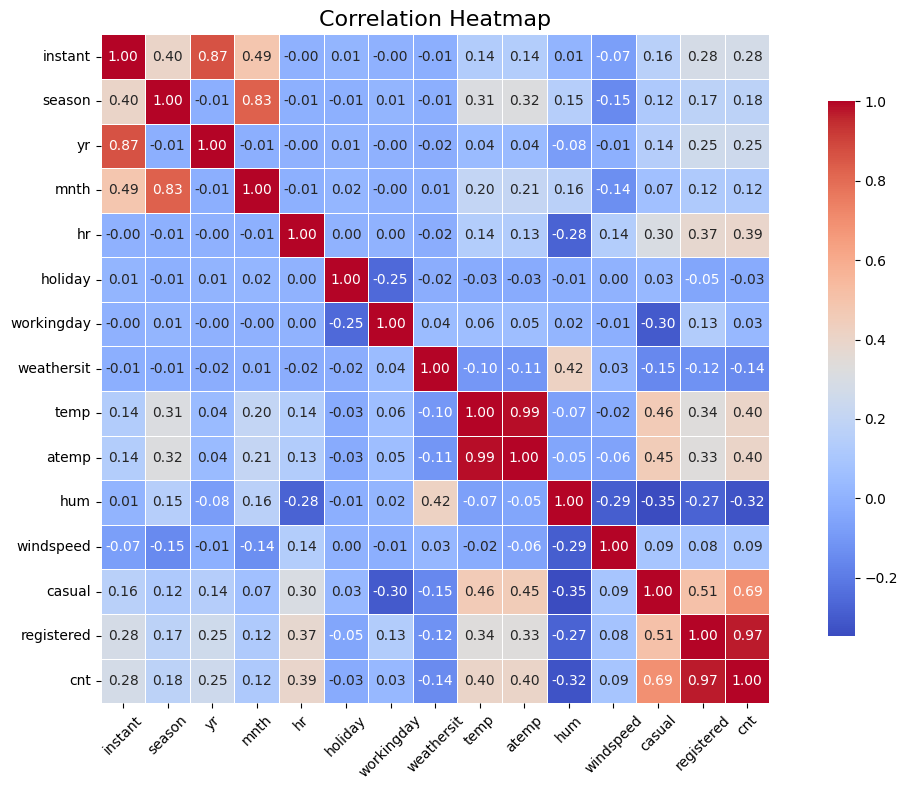

In [473]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr(numeric_only=True)

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

There were a few columns that we knew from the beginning that we would drop: 
- instant
- dteday
- casual
- registered

The heatmap confirms that a few variables have a strong to extremely strong correlation with the target variable (cnt):
- registered with 0.97 --> I was considering it before so I will defineitely drop it now. 
- casual with 0.69 --> I was considering it before so I will defineitely drop it now. 

The heatmap also highlights some strong correlations between features:
- atemp and temp with 0.99 --> This makes sense since the felt temeprature is very similar to the actual one. I will drop atemp to remove redundancy. 
- month and season with 0.83 --> As suspected, season is derived from month so they are redundant. I will keep month. 

In conclusion, I will go ahead and drop instant, dteday, casual, registered, atemp, season

In [474]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(columns=['instant','dteday','casual', 'registered', 'atemp', 'season'])

After dropping the strongly correlated variables identified earlier, I decided to generate a new heatmap. As seen below, no remaining features show strong correlation with each other or with the target. This confirms that the dataset is now cleaner, with minimal redundancy and reduced risk of multicollinearity

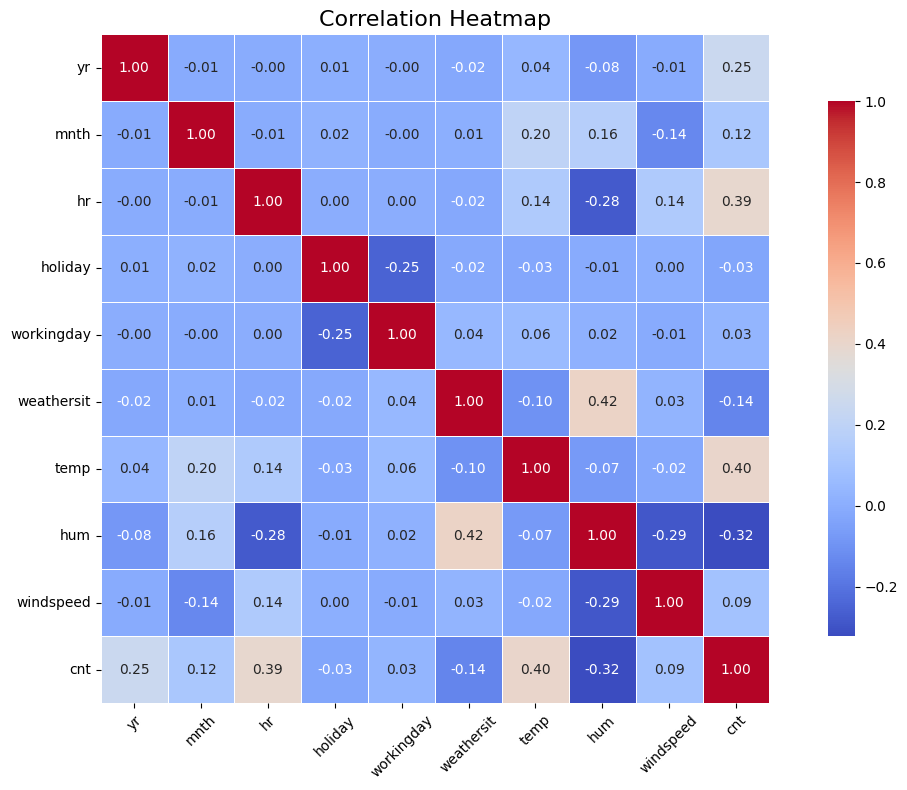

In [475]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned.corr(numeric_only=True)

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Later on, when we encode the necessary variables, we will generate the heatmap again to check if there is need to drop any more features. 

# <font color='#3c3c3c'>Task 2 - Data Splitting</font>

For this task, I will initially follow the recommendation in the guidelines to split into 60/20/20. I can change it later on when I can measure the model's performance. But, for now I believe is a solid decision since this dataset is moderately large enough to balance having enough data to effectively train the model while keeping a meaningful portion for unbiased validation and testing sets.

The suggestion on the guidelines to focus on trying to keep the temporal order really threw me off at first. I discussed it with ChatGPT as to how I could do this. It initally suggested something called "stratification", which at first made sense because it would allow me to split the data based on variables, such as month. Then, when I investigated a bit more about it I realized it wasn't a good choice becuase this splitting strategy was often used for classification models, which is not our case. Then, it suggested to split the data into years; assigning the 2011 entires to the training set and 2012 entries to the validation and test sets. First, I had already dropped the date column (which is where I would have gotten the year) and secondly it didn't make much sense in mind that I directly assigned year to the different sets. Therefore, this idea was almost immediately denied. At this point I went back to the guidelines and go back to actual purpose of the model. I was extremely troubled as to how to split the data keeping the temporal order and keep it randomized at the same time. After much consideration, I realized that maintaining both strict temporal order and randomness simultaneously is fundamentally contradictory: if you shuffle the data, you lose the order; if you preserve the order, you lose randomness. I'm not sure if my logic is correct but given that the model's task is to predict bike rental counts on an HOURLY basis and that the temporal features will be captured later through feature engineering I will split the data as I normaly would, completely randomized. This way, when I encode the temporal features, like hr, the model won't be able to access the future. 

In [476]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the dataset into training (60%), validation (20%), and test (20%) sets
train, temp = train_test_split(df_cleaned, test_size=0.4, random_state=42)  # 60% training data
val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 20% validation, 20% test data

# Check the splits
print("Training set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)



Training set shape: (10427, 11)
Validation set shape: (3476, 11)
Test set shape: (3476, 11)


I printed the shape of the sets to make sure they were splitted correctly. 
- training set --> 10427 / 17379 = **59.997698**
- validation set --> 3476/ 17379 = **20.0001151**
- test set --> 3476/ 17379 = **20.0001151**

They are!

Before moving on to the next task I want to briefly check if the sets are balanced. So, I will print the number of rentals per set.

In [477]:
# Check the total count of the target variable in each split
print("Total target count in Training Set:", train['cnt'].sum())
print("Total target count in Validation Set:", val['cnt'].sum())
print("Total target count in Test Set:", test['cnt'].sum())



Total target count in Training Set: 1996563
Total target count in Validation Set: 653391
Total target count in Test Set: 642725


The proportions appear reasonable given the 60%/20%/20% split. The training set has approximately 60% of the total target count, while the validation and test sets each have around 20%. Nevertheless, just to be 100% sure I want to print the distirbution of the target variable in eahc set.

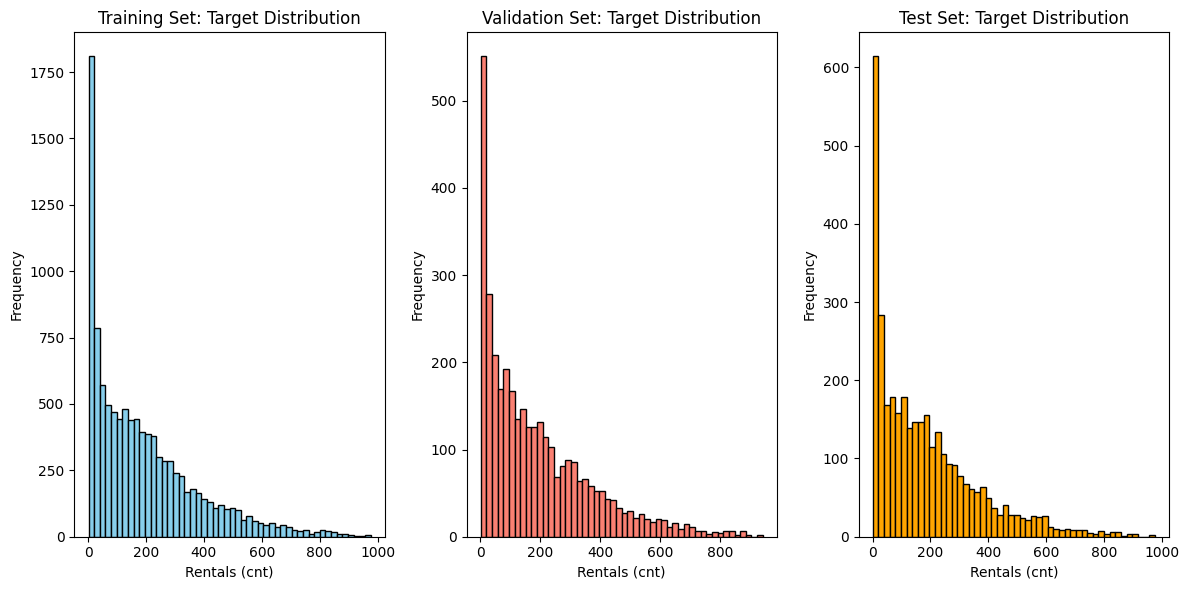

In [478]:
import matplotlib.pyplot as plt

# Plot histograms for target variable ('cnt') in each dataset
plt.figure(figsize=(12, 6))

# Training set
plt.subplot(1, 3, 1)
plt.hist(train['cnt'], bins=50, color='skyblue', edgecolor='black')
plt.title('Training Set: Target Distribution')
plt.xlabel('Rentals (cnt)')
plt.ylabel('Frequency')

# Validation set
plt.subplot(1, 3, 2)
plt.hist(val['cnt'], bins=50, color='salmon', edgecolor='black')
plt.title('Validation Set: Target Distribution')
plt.xlabel('Rentals (cnt)')
plt.ylabel('Frequency')

# Test set
plt.subplot(1, 3, 3)
plt.hist(test['cnt'], bins=50, color='orange', edgecolor='black')
plt.title('Test Set: Target Distribution')
plt.xlabel('Rentals (cnt)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


The graphs shows that the distribution of the target variable was kept the same through the sets, so the now I can confirm that the data is balanced. This means that we are doing a good job at making sure that the model has no bias. 

# <font color='#3c3c3c'>Task 3 - Feature Engineering</font>

Before starting with the encoding process, I first want to print the current features present in the dataset. This way I will not forget to encode any feature.

In [479]:
# Check the datatypes of the training set features
print("Training set datatypes:")
print(train.dtypes)

# Optional: peek at first few rows for more clarity
train.head()

Training set datatypes:
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday        object
workingday      int64
weathersit      int64
temp          float64
hum           float64
windspeed     float64
cnt             int64
dtype: object


,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
3219,0,5,1,0,Thursday,1,1,0.50,0.94,0.0000,6
14197,1,8,18,0,Sunday,0,2,0.64,0.78,0.1045,377
6282,0,9,8,0,Saturday,0,2,0.58,0.90,0.0896,121
16019,1,11,4,0,Monday,1,2,0.30,0.52,0.2537,16
7449,0,11,0,0,Saturday,0,1,0.24,0.60,0.1343,64


Now that we can see the features that are still on our dataset, I will proceed to list what encoding strategy I will use for each one: 
- **yr** → **one-hot encoding** because it's a categorical feature representing the year, 2011 or 2012, this will help us remove the order so that the model won't see the future 

- **mnth** → **one-hot encoding** because it's a categorical feature representing months 1–12. Again, this will help us to remove the order and the model to treat each month as a different category without accessing the future

- **hr** → **sine and cosine transformation** because hours are cyclical (0–23), meaning 23:00 and 00:00 are conceptually close, and sine and cosine transforms preserve this cyclical nature or order

- **holida**y → stays the same because it's binary

- **weekday** → **sine and cosine transformation**  because even though it is categorical, Monday to Sunday, there is an important order to mantian since some days are closer to others.

- **workingday** → stays the same because it's already binary 

- **weathersit** → **one-hot encoding** because it's categorical representing different weather situations 

- **temp** → **scaling** because it's a continuous feature representing the different degrees in temperature. Scaling will normalize the data and make sure the model treats it correctly.

- **hum** → **scaling** because it's a continuous feature representing humidity, and scaling will allow the model to handle it with no issues

- **windspeed** → **scaling** because it's a continuous feature representing wind speed. Again, this will allow the model to treat it accordingly

Now, we can move on to the encoding process.

In [480]:
import numpy as np
import pandas as pd

# Function to encode cyclical features (Sine & Cosine transformations)
def encode_cyclical(df, column):
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max(df[column]))
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max(df[column]))
    df = df.drop(columns=[column])  # Drop original column
    return df

# Mapping weekdays to numbers
weekday_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Apply the mapping to 'weekday' column
train['weekday'] = train['weekday'].map(weekday_map)
val['weekday'] = val['weekday'].map(weekday_map)
test['weekday'] = test['weekday'].map(weekday_map)

# Apply the cyclical encoding
train = encode_cyclical(train, 'hr')
val = encode_cyclical(val, 'hr')
test = encode_cyclical(test, 'hr')

train = encode_cyclical(train, 'weekday')
val = encode_cyclical(val, 'weekday')
test = encode_cyclical(test, 'weekday')


In [481]:
# Here i am just checking that the original column is gone and that there are four new columns
train.head()

,yr,mnth,holiday,workingday,weathersit,temp,hum,windspeed,cnt,hr_sin,hr_cos,weekday_sin,weekday_cos
3219,0,5,0,1,1,0.50,0.94,0.0000,6,0.269797,0.962917,1.224647e-16,-1.0
14197,1,8,0,0,2,0.64,0.78,0.1045,377,-0.979084,0.203456,-2.449294e-16,1.0
6282,0,9,0,0,2,0.58,0.90,0.0896,121,0.816970,-0.576680,-8.660254e-01,0.5
16019,1,11,0,1,2,0.30,0.52,0.2537,16,0.887885,0.460065,0.000000e+00,1.0
7449,0,11,0,0,1,0.24,0.60,0.1343,64,0.000000,1.000000,-8.660254e-01,0.5


In [482]:
onehot_cols = ['mnth', 'weathersit', 'yr']

# One-hot encode training 
train = pd.get_dummies(train, columns=onehot_cols, drop_first=True)
val = pd.get_dummies(val, columns=onehot_cols, drop_first=True)
test = pd.get_dummies(test, columns=onehot_cols, drop_first=True)

# applying to test and validation sets
val = val.reindex(columns=train.columns, fill_value=0)
test = test.reindex(columns=train.columns, fill_value=0)

In [483]:
train.head()

,holiday,workingday,temp,hum,windspeed,cnt,hr_sin,hr_cos,weekday_sin,weekday_cos,...,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_2,weathersit_3,weathersit_4,yr_1
3219,0,1,0.50,0.94,0.0000,6,0.269797,0.962917,1.224647e-16,-1.0,...,False,False,False,False,False,False,False,False,False,False
14197,0,0,0.64,0.78,0.1045,377,-0.979084,0.203456,-2.449294e-16,1.0,...,False,True,False,False,False,False,True,False,False,True
6282,0,0,0.58,0.90,0.0896,121,0.816970,-0.576680,-8.660254e-01,0.5,...,False,False,True,False,False,False,True,False,False,False
16019,0,1,0.30,0.52,0.2537,16,0.887885,0.460065,0.000000e+00,1.0,...,False,False,False,False,True,False,True,False,False,True
7449,0,0,0.24,0.60,0.1343,64,0.000000,1.000000,-8.660254e-01,0.5,...,False,False,False,False,True,False,False,False,False,False


In [484]:
from sklearn.preprocessing import StandardScaler

scale_cols = ['temp', 'hum', 'windspeed']

scaler = StandardScaler()

# first on training data 
train[scale_cols] = scaler.fit_transform(train[scale_cols])

# now in both test and validaiton
val[scale_cols] = scaler.transform(val[scale_cols])
test[scale_cols] = scaler.transform(test[scale_cols])


In [485]:
# Here I am just checking that the scalar was applied to the correct columns
train.head()

,holiday,workingday,temp,hum,windspeed,cnt,hr_sin,hr_cos,weekday_sin,weekday_cos,...,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_2,weathersit_3,weathersit_4,yr_1
3219,0,1,0.010779,1.617165,-1.553977,6,0.269797,0.962917,1.224647e-16,-1.0,...,False,False,False,False,False,False,False,False,False,False
14197,0,0,0.737229,0.789210,-0.698230,377,-0.979084,0.203456,-2.449294e-16,1.0,...,False,True,False,False,False,False,True,False,False,True
6282,0,0,0.425893,1.410176,-0.820246,121,0.816970,-0.576680,-8.660254e-01,0.5,...,False,False,True,False,False,False,True,False,False,False
16019,0,1,-1.027007,-0.556216,0.523563,16,0.887885,0.460065,0.000000e+00,1.0,...,False,False,False,False,True,False,True,False,False,True
7449,0,0,-1.338343,-0.142239,-0.454199,64,0.000000,1.000000,-8.660254e-01,0.5,...,False,False,False,False,True,False,False,False,False,False


### <font color='6e6e6e'>Are there any columns to drop?</font>

Now we have a bit more columns in our dataset after the encoding, which means that the correlation heatmap will be difficult to vosuzalize. Therefore, to analyze any further possible multicollinearity between the features, I will print those pair of features that have a mulicollineairty greater than 0.7 to check if we should drop any more features. 

In [486]:
import pandas as pd

# Compute the correlation matrix (exclude non-numeric if needed)
corr_matrix = train.corr().abs()

# Mask the diagonal and lower triangle
upper_triangle_mask = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Filter correlations greater than 0.7
high_corr = upper_triangle_mask.stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = high_corr[high_corr['Correlation'] > 0.7]

# Print
print("Highly correlated feature pairs (correlation > 0.7):")
print(high_corr.sort_values(by='Correlation', ascending=False))

Highly correlated feature pairs (correlation > 0.7):
Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


As the results show, there is no strong correlations, so I will not drop any more columns for now. 

# <font color='#3c3c3c'>Task 4 - Baseline Model – Linear Regression</font>

Before training the models, I remove the target variable (cnt) from the training and validation feature sets to prevent data leakage and ensure the models only learn from the input features.

In [487]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target_col = 'cnt'

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_val = val.drop(columns=[target_col])
y_val = val[target_col]


Now I can go ahead and start by intiializing a simple linear regression model and train it using the training data. This will serve as a basline model so that we can compare the performance of the other models.

In [488]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [489]:
y_pred = lin_reg.predict(X_val)

mse_lr = mean_squared_error(y_val, y_pred)
mae_lr = mean_absolute_error(y_val, y_pred)
r2_lr = r2_score(y_val, y_pred)

print("Linear Regression Evaluation on Validation Set:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")

Linear Regression Evaluation on Validation Set:
Mean Squared Error (MSE): 16307.85
Mean Absolute Error (MAE): 93.90
R² Score: 0.50


The results show a poor perfromance. Let's go over the three performance measurements:

- **Mean Squared Error (MSE)**: 16,307.85
The model has an extremely high MSE value, which is the opposite of what we look for in performance. In regression, a lower MSE is what we want, as it reflects smaller errors. This score means that the predictions of the model are very far from the actual values.

- **Mean Absolute Error (MAE)**: 93.90
This tells us that on average, the model's predictions are off by about 94 rentals. Which again, is not the best. 

- **R² Score**: 0.50
This means the model explains about 50% of the variance in the target variable. While this is a decent starting point, it also shows that linear regression isn't capturing more complex patterns in the data. This is exactly what we suspected in the EDA, since the model showed a skewed distribution and complex patterns.

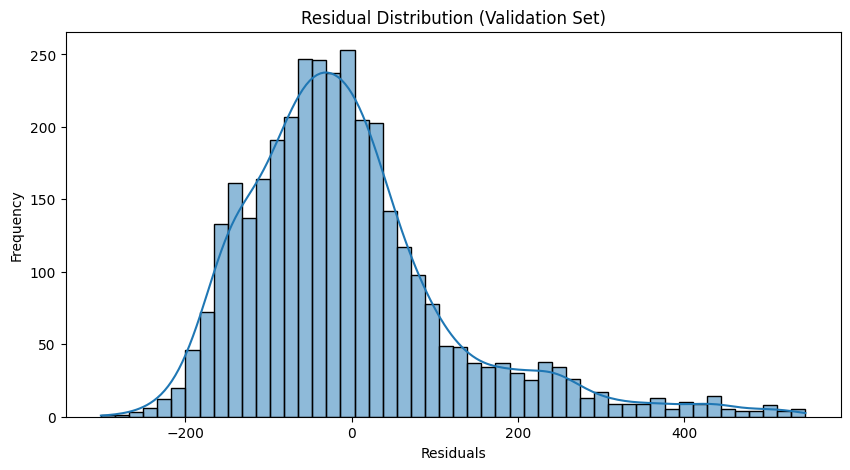

In [490]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_val - y_pred

# Residual Plot
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Validation Set)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [511]:
y_train_pred = lin_reg.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training R² Score: {train_r2:.2f}")
print(f"Validation R² Score: {r2_lr:.2f}")


Training R² Score: 0.49
Validation R² Score: 0.50


The residual histogram is right-skewed, with the majority of residuals being negative. This suggests that the model tends to overfit (though this is counterintuitive, as we expect underfitting due to the simplicity of the model) rental counts for most hours. This overfitting happens because when we subtract the actual value from the predicted value, we get the residuals. If the residual is positive, it means the model is underpredicting, and if the residual is negative, it means the model is overpredicting.

However, the right-skew indicates that during high-rental periods, the model significantly underpredicts, leading to large positive residuals (values > 400). This was initially confusing because I didn't realize it was possible for the model to both underfit and overfit at the same time. But it made sense when I revisited the EDA. The model fails to properly capture the peak demand periods that were observed in the data, where we analyzed the relationship between rentals and time of day.

In conclusion, when reflecting on whether the model is underfitting or overfitting, it’s clear that it’s doing both: the model underfits the large rental counts (due to a simple linear relationship) and overfits the smaller rental counts (because the model fits the training data well but does not generalize to larger values). This suggests that the model suffers from both high bias and high variance. The R² scores being nearly the same on both the training and validation sets indicate that the model is likely underfitting rather than overfitting. This suggests the model is too simple to capture the complex patterns in the data. These findings support the idea that a simple linear model may be too limited for this problem and that a more complex model are have a better chance at capturing the complex patterns.


# <font color='#3c3c3c'>Task 5 - Random Forest Regressor - Model Specification and Training</font>

In [508]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

In [509]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest Regressor - Evaluation Metrics:")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)

Random Forest Regressor - Evaluation Metrics:
MSE: 2061.3800082788716
MAE: 27.838892973587594
R²: 0.9365734552375035


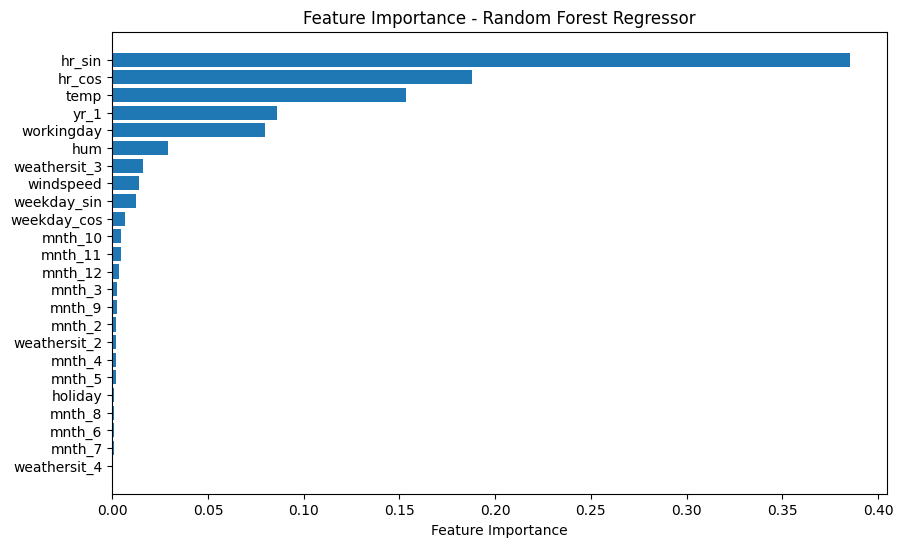

In [495]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the feature importances from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame for easy visualization
features = X_train.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest Regressor')
plt.show()

In [496]:
# Get the feature importance from the trained Random Forest model
importances = rf_model.feature_importances_

# Create a DataFrame to display feature names and their importance
import pandas as pd

# Assuming you have a list of feature names stored in a variable called 'features'
feature_names = X_train.columns  # Replace with the appropriate feature names if needed
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)


         Feature  Importance
5         hr_sin    0.385479
6         hr_cos    0.188006
2           temp    0.153537
23          yr_1    0.085913
1     workingday    0.079852
3            hum    0.029031
21  weathersit_3    0.016062
4      windspeed    0.013954
7    weekday_sin    0.012241
8    weekday_cos    0.006808
17       mnth_10    0.004696
18       mnth_11    0.004397
19       mnth_12    0.003364
10        mnth_3    0.002316
16        mnth_9    0.002311
9         mnth_2    0.002111
20  weathersit_2    0.001986
11        mnth_4    0.001912
12        mnth_5    0.001845
0        holiday    0.001135
15        mnth_8    0.001102
13        mnth_6    0.000995
14        mnth_7    0.000946
22  weathersit_4    0.000003


In [497]:
# Comparison summary
print("\nComparison of Models:")
print(f"Linear Regression MSE: {mse_lr} | Random Forest MSE: {mse_rf}")
print(f"Linear Regression MAE: {mae_lr} | Random Forest MAE: {mae_rf}")
print(f"Linear Regression R²: {r2_lr} | Random Forest R²: {r2_rf}")


Comparison of Models:
Linear Regression MSE: 16307.84849965881 | Random Forest MSE: 2061.3800082788716
Linear Regression MAE: 93.89770459996119 | Random Forest MAE: 27.838892973587594
Linear Regression R²: 0.4982242581719599 | Random Forest R²: 0.9365734552375035


# <font color='#3c3c3c'>Task 6 - Gradient Boosting Regressor - Model Specification and Training</font>

In [498]:
!pip3 install xgboost lightgbm matplotlib seaborn scikit-learn

269203.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

In [500]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_val)

In [501]:
mse_gbr = mean_squared_error(y_val, y_pred)
mae_gbr = mean_absolute_error(y_val, y_pred)
r2_gbr = r2_score(y_val, y_pred)

In [502]:
print("\nComparison of Models:")
print(f"Linear Regression MSE: {mse_lr} | Gradient Boosting Regressor MSE: {mse_gbr}")
print(f"Linear Regression MAE: {mae_lr} | Gradient Boosting Regressor MAE: {mae_gbr}")
print(f"Linear Regression R²: {r2_lr} | Gradient Boosting Regressor R²: {r2_gbr}")


Comparison of Models:
Linear Regression MSE: 16307.84849965881 | Gradient Boosting Regressor MSE: 1828.72900390625
Linear Regression MAE: 93.89770459996119 | Gradient Boosting Regressor MAE: 27.432836532592773
Linear Regression R²: 0.4982242581719599 | Gradient Boosting Regressor R²: 0.9437319040298462


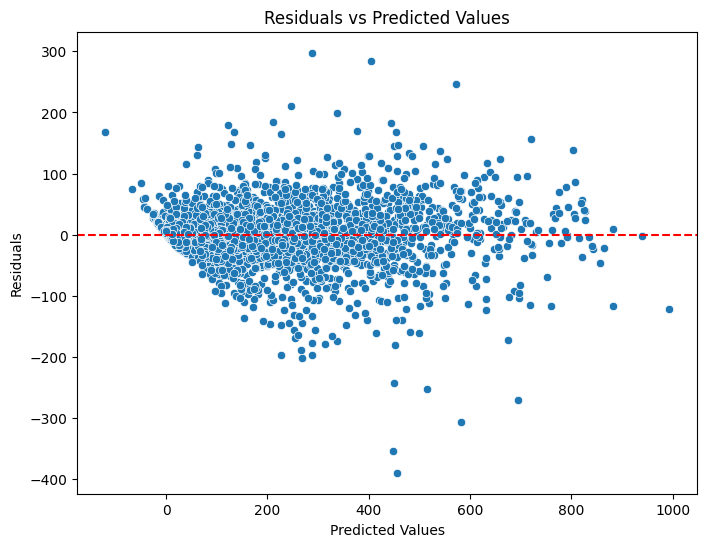

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_val - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# <font color='#3c3c3c'>Task 7 - Hyperparameter Tuning</font>

### <font color='6e6e6e'>Random Forest</font>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': np.arange(50, 500, 50),  
    'max_depth': np.arange(10, 101, 10),  
    'min_samples_split': np.arange(2, 21, 2),  
    'min_samples_leaf': np.arange(1, 21, 2)  
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {random_search.best_params_}")

best_rf = random_search.best_estimator_
print(f"Validation performance (R^2 score): {best_rf.score(X_val, y_val)}")

importances = best_rf.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
print(f"Updated feature importance:\n")
for idx in sorted_idx:
    print(f"{X_train.columns[idx]}: {importances[idx]:.4f}")


Best parameters for Random Forest: {'n_estimators': np.int64(200), 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(1), 'max_depth': np.int64(80)}
Validation performance (R^2 score): 0.9363797947560194
Updated feature importance:

hr_sin: 0.3909
hr_cos: 0.1896
temp: 0.1532
yr_1: 0.0870
workingday: 0.0812
hum: 0.0269
weathersit_3: 0.0159
weekday_sin: 0.0115
windspeed: 0.0115
weekday_cos: 0.0058
mnth_10: 0.0044
mnth_11: 0.0042
mnth_12: 0.0031
mnth_3: 0.0022
mnth_9: 0.0021
mnth_2: 0.0021
mnth_4: 0.0017
mnth_5: 0.0016
weathersit_2: 0.0015
holiday: 0.0010
mnth_8: 0.0009
mnth_6: 0.0009
mnth_7: 0.0008
weathersit_4: 0.0000


### <font color='6e6e6e'>Gradient Boosting</font>

In [505]:
!pip install scikit-optimize

269466.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [ ]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

param_space = {
    'learning_rate': (0.001, 0.1, 'uniform'),  # Step size shrinking
    'n_estimators': (50, 500),  # Number of trees
    'max_depth': (3, 12),  # Maximum depth of the tree
    'subsample': (0.5, 1.0, 'uniform')  # Fraction of samples used for fitting trees
}

gb = GradientBoostingRegressor(random_state=42)

opt = BayesSearchCV(gb, param_space, n_iter=50, cv=5, verbose=0, n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)
print(f"Best parameters for Gradient Boosting: {opt.best_params_}")

best_gb = opt.best_estimator_
print(f"Validation performance (R^2 score): {best_gb.score(X_val, y_val)}")

Best parameters for Gradient Boosting: OrderedDict({'learning_rate': 0.03870848540734895, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.5})
Validation performance (R^2 score): 0.9491393226205025


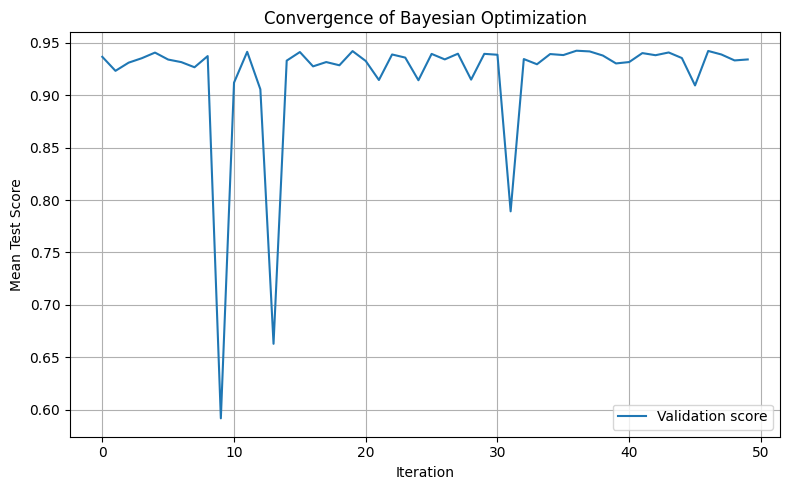

In [507]:
import matplotlib.pyplot as plt

# Assuming `opt` is your BayesSearchCV object
# Extract the convergence information from the optimization history
results = opt.cv_results_

# Extract the loss values or the validation scores
# If you're optimizing for score, use 'mean_test_score'
# If you're optimizing for loss, use 'mean_test_score'
scores = results['mean_test_score']

# Plot the convergence
plt.figure(figsize=(8, 5))
plt.plot(range(len(scores)), scores, label='Validation score')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score')
plt.title('Convergence of Bayesian Optimization')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


# <font color='#3c3c3c'>Task 8 - Iterative Evaluation and Refinement</font>

# <font color='#3c3c3c'>Task 9 - Final Model Selection and Testing</font>